In [ ]:
#|default_exp scheds

# Schedulers for miniai

In [ ]:
#|export
import torch
import fastcore.all as fc
import numpy as np
from torch import tensor
import math

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt

from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

  0%|          | 0/2 [00:00<?, ?it/s]

## Simple Scheduler

### Exponential scheduler for learning rate
An exponential scheduler implementation that works with PyTorch's optimizers and miniai callbacks.

In [ ]:
# function from fastai schedule
def sched_exp(start, end, pos): return start * (end/start) ** pos

In [ ]:
class ExpSchedLR():
    def __init__(self, optimizer, T_max, start=None, end=0):
        self.optimizer = optimizer
        self.final_i = T_max - 1
        self.end = end
        if not start:
            self.starts = [group['lr'] for group in optimizer.param_groups]
        else: 
            self.starts = [start for group in optimizer.param_groups]
        self._step_count = 0
        self.step()

    def step(self):
        values = self.get_lr()
        for data in zip(self.optimizer.param_groups, values):
            pg, lr = data
            pg['lr'] = lr
        self._step_count += 1

    def get_lr(self):
        pos = self._step_count
        return [sched_exp(start, self.end, pos/self.final_i) for start in self.starts]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

def _lr(cb): return cb.pg['lr']
rec = RecorderCB(lr=_lr)
rec.order = -1 # To record before the update by the scheduler

In [ ]:
epochs = 1
tmax = epochs * len(dls.train)

sched = partial(ExpSchedLR, T_max=tmax, end=0.005)

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
xtra = [BatchSchedCB(sched), rec]
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

accuracy,loss,epoch,train
0.804,0.528,0,train
0.850,0.401,0,eval


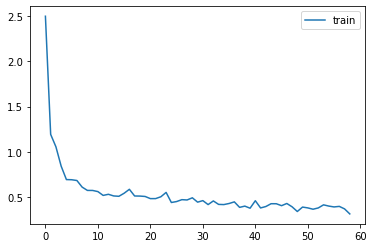

In [ ]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

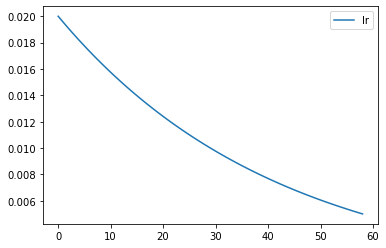

In [ ]:
rec.plot()

In [ ]:
rec.recs['lr'][0], rec.recs['lr'][-1]

(0.02, 0.005)

## Flexible Scheduler
Very much based on fastai's schedulers, implemented for miniai.

### Definition of schedulers
#### Exponential

In [ ]:
def sched_exp(start, end, gamma, pos): 
    assert gamma>=0 and gamma<=1
    pos,final_pos = pos*100, 100
    theta = gamma**final_pos / final_pos
    return (start-end)*gamma**pos + (end-start)*theta*pos + end

PyTorch's `ExponentialLR` implementation differs from fastai's `SchedExp`. `ExponentialLR` has a `gamma` parameter that modifies the convergence speed, but unlike `SchedExp`, doesn't converge to a defined end value.

Here, for miniai, the implementation uses a `gamma` parameter that modifies the curve, and also has a defined end value.

The problem is that a `gamma` distributed between 0 and 1 doesn't produce smooth steps for `sched_exp` results.

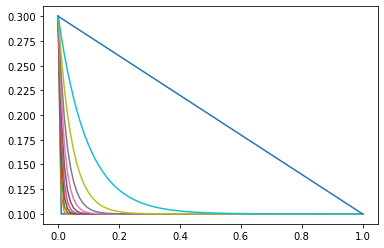

In [ ]:
xi = torch.linspace(0, 1, 100)
gammas = [round(g.item(), 1) for g in torch.linspace(0, 1, 11)]

for g in gammas:
    yi = [sched_exp(0.3,0.1,g,i) for i in xi]
    plt.plot(xi, yi, label=l)

So, after iterating with excel trendlines and `gamma`values, a transformation was found that generates a smooth distribution for `sched_exp`.

In [ ]:
#|export
def smooth_gamma(gamma):
    gamma = 1 + 7 * gamma
    return 0.000268*gamma**3-0.005078*gamma**2+0.039773*gamma+0.864643

def sched_exp(start, end, gamma, pos): 
    assert gamma>=0 and gamma<=1
    pos,final_pos = pos*100, 100
    g = smooth_gamma(gamma)
    theta = g**final_pos / final_pos
    return (start-end)*g**pos + (end-start)*theta*pos + end

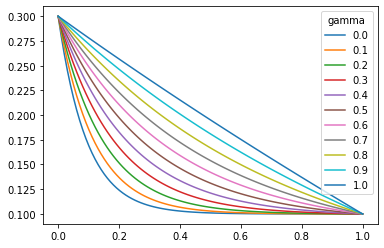

In [ ]:
xi = torch.linspace(0, 1, 100)
gammas = [round(g.item(), 1) for g in torch.linspace(0, 1, 11)]

for g in gammas:
    yi = [sched_exp(0.3,0.1,g,i) for i in xi]
    plt.plot(xi, yi, label=l)
    plt.legend(gammas, title='gamma');

#### Cosine, Poly, Linear, No and fastai's Exponential

In [ ]:
#|export
def sched_cos(start, end, pos): return end + (start - end)/2 * (1 + math.cos(pos*math.pi))
def sched_poly(start, end, power, pos): return start + (end - start) * pos ** power
def sched_fastai_exp(start, end, pos): return start * (end/start) ** pos

In [ ]:
#|export
class _Annealer:
    def __init__(self, f, start, end): fc.store_attr()
    def __call__(self, pos): return self.f(start=self.start, end=self.end, pos=pos)

In [ ]:
#|export
def SchedCos(start, end): return _Annealer(sched_cos, start, end)
def SchedExp(start, end, gamma): return _Annealer(partial(sched_exp, gamma=gamma), start, end)
def SchedExpFastai(start, end): return _Annealer(sched_fastai_exp, start, end)
def SchedLin(start, end): return _Annealer(partial(sched_exp, gamma=1), start, end)
def SchedNo(start): return _Annealer(partial(sched_poly, power=0), 0, start)
def SchedPoly(start, end, power): return _Annealer(partial(sched_poly, power=power), start, end)

#### Ploting different schedulers

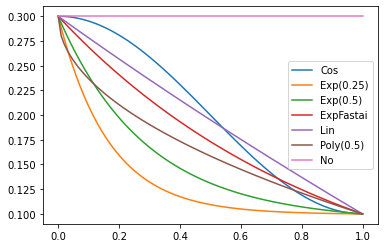

In [ ]:
xi = torch.linspace(0, 1, 100)

labels = "Cos Exp(0.25) Exp(0.5) ExpFastai Lin Poly(0.5) No".split()
scheds = [SchedCos(0.3, 0.1), SchedExp(0.3, 0.1, .25), 
          SchedExp(0.3, 0.1, .5), SchedExpFastai(0.3, 0.1), 
          SchedLin(0.3, 0.1), SchedPoly(0.3,0.1,0.5), SchedNo(0.3)]

for sched, l in zip(scheds, labels):
    yi = [sched(i) for i in xi]
    plt.plot(xi, yi, label=l)
    plt.legend();

### Classes to combine basic scheduler's functions

Based on fastai's `combine_scheds` and `combined_cos` functions:

In [ ]:
#|export
class CombineScheds:
    "Combine `scheds` according to `pcts` in one class"
    def __init__(self, pcts, scheds):
        assert sum(pcts) == 1.
        assert (len(pcts)>=2) and (len(pcts)==len(scheds))
        pcts = tensor([0] + pcts)
        assert torch.all(pcts >= 0)
        self.scheds = scheds
        self.pcts = torch.cumsum(pcts, 0)
        self.pct_lim = len(self.pcts) - 2
    
    def _get_idx_apos(self, pos):
        idx = min((pos >= self.pcts).nonzero().max(), self.pct_lim)
        actual_pos = (pos-self.pcts[idx]) / (self.pcts[idx+1]-self.pcts[idx])
        return idx, actual_pos
        
    def __call__(self, pos):
        idx, actual_pos = self._get_idx_apos(pos)
        return self.scheds[idx](pos=actual_pos.item())

    @property
    def start(self): return self.scheds[0].start

    @start.setter
    def start(self, value): self.scheds[0].start = value

In [ ]:
#|export
class CombinedCos(CombineScheds):
    "Return a scheduler with cosine annealing from `start`→`middle` & `middle`→`end`"
    def __init__(self, pct, start, middle, end):
        super().__init__([pct,1-pct], [SchedCos(start, middle), SchedCos(middle, end)])

### Helper functions and hyperparams' mapping to PyTorch's optimizers

In [ ]:
#|export
# hyperparameters map
mai_hp_map = {'lr': 'lr', 'momentum': 'mom', 'betas__0': 'mom', 'betas__1': 'sqr_mom'}

In [ ]:
#|export
# based on fastai's functions (some are the same as fastai's)
def detuplify_pg(d):
    res = {}
    for k,v in d.items():
        if k == 'params': continue
        if fc.is_listy(v): 
            res.update(**{f'{k}__{i}': v_ for i,v_ in enumerate(v)})
        else: res[k] = v
    return res

def set_item_pgs(pgs, k, vs):
    for v, pg in zip(vs, pgs):
        if '__' not in k: pg[k] = v
        else:
            name,idx = k.split('__')
            pg[name] = tuple(v if i==int(idx) else pg[name][i] for i in fc.range_of(pg[name]))

def get_item_pgs(pgs, k):
    res = []
    for pg in pgs:
        if '__' not in k: res.append(pg[k])
        else:
            name,idx = k.split('__')
            res.append(pg[name][int(idx)])
    return np.array(res)

def mapping(pgs, scheds):
        n_pgs = len(pgs)
        fwd_map = {k: v for k,v in mai_hp_map.items() if k in detuplify_pg(pgs[0]).keys()}
        bwd_map = {k: v for v,k in fwd_map.items() if k in scheds.keys()}
        return fwd_map, bwd_map

def format_start(v, n_pgs):
    v = [v] if isinstance(v, (int, float)) else v
    v = list(v)
    if len(v)==1: v = v * n_pgs
    assert len(v) == n_pgs, f"Trying to set {len(v)} values, but there are {n_pgs} parameter groups."
    return np.array(v)

### Parameter Scheduler Class

In [ ]:
#|export
class ParamScheduler:
    "Scheduler for multiple hyperparameters and groups"
    def __init__(self, scheds, total_steps, optimizer):
        self.opt = optimizer
        self.final_step = total_steps - 1
        self.scheds = scheds
        self.pgs = optimizer.param_groups
        self._step_count = 0
        self._init_sched()
        self.step()

    def step(self):
        pct_train = self._step_count / self.final_step
        if pct_train <= 1: 
            for k, sched in self.scheds.items():
                vs = sched(pct_train)
                set_item_pgs(self.pgs, self.bwd_map[k], vs)
        self._step_count += 1

    def _init_sched(self):
        self.fwd_map, self.bwd_map = mapping(self.pgs, self.scheds)
        n_pgs = len(self.pgs)
        for k, sched in self.scheds.items():
            if not sched.start: sched.start = get_item_pgs(self.pgs, self.bwd_map[k])
            else: sched.start = format_start(sched.start, n_pgs)
            if isinstance(sched, CombineScheds):
                for sc in sched.scheds[1:]: sc.start = format_start(sc.start, n_pgs)

### `OneCycleSched` and `FlatCosSched`

In [ ]:
#|export
class OneCycleSched(ParamScheduler):
    "OneCycle ParamScheduler"
    def __init__(self, optimizer, total_steps, lr_max=None, div=25., div_final=1e5, pct_start=0.25, moms=None):
        fc.store_attr()
        self.pgs = optimizer.param_groups
        self._init_onecycle_sched()
        super().__init__(self.scheds, total_steps, optimizer)
    
    def _init_onecycle_sched(self):
        if not self.lr_max: self.lr_max = get_item_pgs(self.pgs, 'lr')
        if not self.moms: self.moms = (0.95, 0.85, 0.95)
        self.scheds = {'lr':  CombinedCos(self.pct_start, self.lr_max/self.div, self.lr_max, self.lr_max/self.div_final),
            'mom': CombinedCos(self.pct_start, *self.moms)}

In [ ]:
#|export
class FlatCosSched(ParamScheduler):
    "FlatCos ParamScheduler"
    def __init__(self, optimizer, total_steps, lr=None, div_final=1e5, pct_start=0.75):
        fc.store_attr()
        self.pgs = optimizer.param_groups
        self._init_flatcos_sched()
        super().__init__(self.scheds, total_steps, optimizer)
    
    def _init_flatcos_sched(self):
        if not self.lr: self.lr = get_item_pgs(self.pgs, 'lr')
        self.scheds = {'lr':  CombinedCos(self.pct_start, self.lr, self.lr, self.lr/self.div_final)}

## Training with flexible schedulers

In [ ]:
epochs = 1
tmax = epochs * len(dls.train)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)
rec.order = -1

cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

### `ParamScheduler` with `CombineScheds`

`ParamScheduler` receives a dictionary with the hyperparameters to modify as keys, and the scheds as its values. In this example receives a `CombineScheds` for both `lr` and `mom`.  

If the `start` is `None`, the scheduler takes the start value from the optimizer, for the given parameter.

In [ ]:
sched = {'lr':  CombineScheds([.3,.7], [SchedExp(None, 1e-2, gamma=.5), 
                                        SchedCos(1e-2, 1e-3)]),
         'mom': CombineScheds([.3,.7], [SchedLin(None, .85), 
                                        SchedCos(.85, .95)])}

sched_cb = partial( ParamScheduler, sched, tmax )
xtra = [BatchSchedCB(sched_cb), rec]

accuracy,loss,epoch,train
0.806,0.530,0,train
0.848,0.412,0,eval


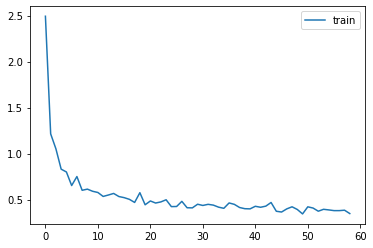

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)

cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2.1e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

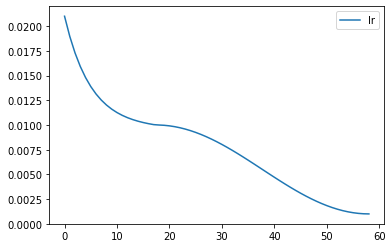

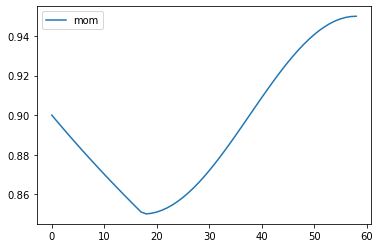

In [ ]:
rec.plot()

### `OneCycle`

In [ ]:
sched_cb = partial( OneCycleSched, total_steps=tmax )
xtra = [BatchSchedCB(sched_cb), rec]

accuracy,loss,epoch,train
0.776,0.625,0,train
0.850,0.407,0,eval


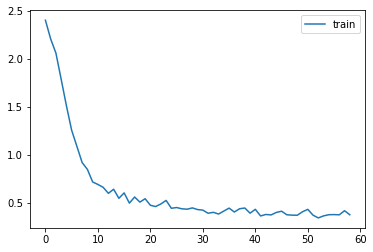

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)

cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

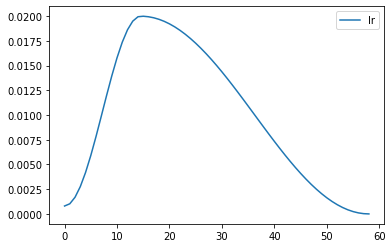

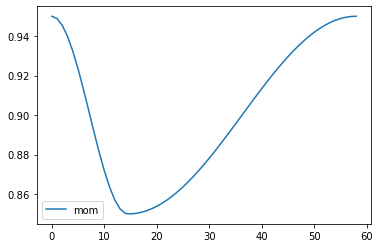

In [ ]:
rec.plot()

In [ ]:
rec.recs['lr'][0], rec.recs['lr'][15], rec.recs['lr'][-1]

(0.0007999999999999986, 0.01999348103498009, 2e-07)

In [ ]:
rec.recs['mom'][0], rec.recs['mom'][15], rec.recs['mom'][-1]

(0.95, 0.850032595151051, 0.95)

### `FlatCos`

In [ ]:
sched_cb = partial( FlatCosSched, total_steps=tmax, pct_start=0.35 )

In [ ]:
rec = RecorderCB(lr=_lr)
rec.order = -1

In [ ]:
xtra = [BatchSchedCB(sched_cb), rec]

accuracy,loss,epoch,train
0.801,0.542,0,train
0.854,0.400,0,eval


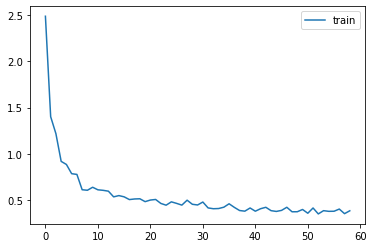

In [ ]:
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)

cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

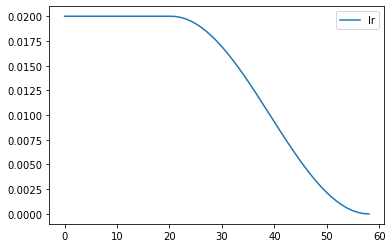

In [ ]:
rec.plot()

In [ ]:
rec.recs['lr'][0], rec.recs['lr'][20], rec.recs['lr'][21], rec.recs['lr'][-1]

(0.02, 0.02, 0.019982991928274872, 2e-07)

## Comparing miniai's OneCycle implementation with PyTorch's

In [ ]:
lr=0.02
epochs = 1
batches = 101

In [ ]:
# miniai OneCycleSched is based on fastai's implementation
opt = torch.optim.AdamW(model.parameters())
miniai_sc = partial(OneCycleSched, 
                    total_steps=epochs*batches, lr_max=lr)(opt)

mini_lrs=[]
for i in range(batches):
    mini_lrs.append(miniai_sc.scheds['lr'](i/100)[0])

In [ ]:
opt = torch.optim.AdamW(model.parameters())
pytorch_sc = partial(lr_scheduler.OneCycleLR, 
                     max_lr=lr, total_steps=epochs*batches)(opt)

In [ ]:
pt_lrs=[]
for batch in range(batches):
    pt_lrs.append(pytorch_sc.get_last_lr()[0])
    pytorch_sc.step()
len(pt_lrs)

101

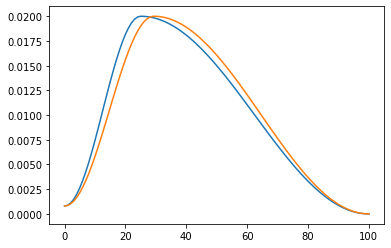

In [ ]:
for yi in (mini_lrs, pt_lrs):
    plt.plot(range(batches), yi);

They differ because:
- **miniai**, as **fastai**, goes from `lr_max/div` to `lr_max` to `lr_max/div_final`, where `div=25` and `div_final=1e5`. Also, the default `pct_start` is 25%.
- **PyTorch** goes from `lr_max/div` to `lr_max` to `lr_max/(div*div_final)`, where `div=25` and `div_final=1e4`. The default `pct_start` is 30%.

So we need to tweek the values.

In [ ]:
# miniai mimicking PyTorch: pct_start=0.3, div_final=25*1e4

opt = torch.optim.AdamW(model.parameters())
miniai_sc = partial(OneCycleSched, total_steps=epochs*batches, 
                    lr_max=lr, pct_start=0.3, div_final=25*1e4)(opt)

mini_lrs=[]
for i in range(batches):
    mini_lrs.append(miniai_sc.scheds['lr'](i/100)[0])

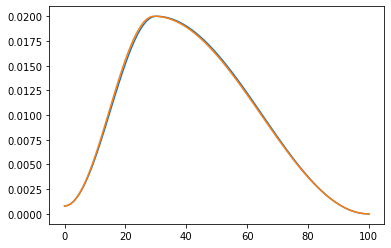

In [ ]:
for yi in (mini_lrs, pt_lrs):
    plt.plot(range(batches), yi);

In [ ]:
mini_lrs[30], pt_lrs[30]

(0.02, 0.01999516284226859)

In [ ]:
test_close(pt_lrs, mini_lrs, eps=1e-03)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()